In [246]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from datetime import datetime
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# !pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
import os
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as skl

np.random.seed(0)

In [247]:
columnName = 'TotalSales'
dataColumnName = 'Date'
dataForDates = pd.read_csv('file.csv')
data = dataForDates.drop(columns=dataColumnName)
data.Discount=data.Discount.mask(data.Discount.lt(0),0)

In [248]:
data.columns

Index(['Unnamed: 0', 'InvoiceID', 'ProductID', 'TotalSales', 'Discount',
       'CustomerID', 'Quantity'],
      dtype='object')

In [249]:
data.head()

,Unnamed: 0,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
0,0,328,1684,796.610169,143.389831,185,4
1,1,329,524,355.932203,64.067797,185,2
2,2,330,192,901.694915,162.305085,230,4
3,3,330,218,182.754237,32.895763,230,1
4,4,330,247,780.101695,140.418305,230,4


###Предобработка данных

In [250]:
dataForDates[dataColumnName] = pd.to_datetime(dataForDates[dataColumnName])
dataForDates.set_index(dataColumnName, inplace= True)
# data =data.resample('D').mean()
dataForDates.head()

,Unnamed: 0,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,,
2019-12-27,0,328,1684,796.610169,143.389831,185,4
2019-12-27,1,329,524,355.932203,64.067797,185,2
2019-12-27,2,330,192,901.694915,162.305085,230,4
2019-12-27,3,330,218,182.754237,32.895763,230,1
2019-12-27,4,330,247,780.101695,140.418305,230,4


Удаление выбросов

In [251]:
# Importing
import sklearn
import pandas as pd
 
# IQR
# Calculate the upper and lower limits
Q1 = data[columnName].quantile(0.10)
Q3 = data[columnName].quantile(0.90)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
 
# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(data[columnName]>=upper)[0]
lower_array = np.where(data[columnName]<=lower)[0]
 
# Removing the outliers
data[columnName].drop(index=upper_array, inplace=True)
data[columnName].drop(index=lower_array, inplace=True)
 
# Print the new shape of the DataFrame
print("New Shape: ", data.shape)

New Shape:  (29103, 7)


In [252]:
data.shape

(29103, 7)

Удаление дублирующихся значений

In [253]:
data.drop_duplicates()
data.shape

(29103, 7)

In [254]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29103 entries, 0 to 29102
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  29103 non-null  int64  
 1   InvoiceID   29103 non-null  int64  
 2   ProductID   29103 non-null  int64  
 3   TotalSales  29103 non-null  float64
 4   Discount    29103 non-null  float64
 5   CustomerID  29103 non-null  int64  
 6   Quantity    29103 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.6 MB


In [255]:
from scipy.interpolate import interp1d

Замена пустых полей средневзвешенными значениями

In [256]:
data[columnName] = data[columnName].interpolate()# we will fill the null row

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29103 entries, 0 to 29102
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  29103 non-null  int64  
 1   InvoiceID   29103 non-null  int64  
 2   ProductID   29103 non-null  int64  
 3   TotalSales  29103 non-null  float64
 4   Discount    29103 non-null  float64
 5   CustomerID  29103 non-null  int64  
 6   Quantity    29103 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.6 MB


In [258]:
train = data

In [259]:
target = columnName
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
dataset_name = 'Table'

In [260]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Set 3


In [261]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

# Список типа int индексов категориальных признаков
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

# Список типа int, количество уникальных значений для категориального признака, новые модальности не могут быть предсказаны
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# Список типа int размеров вложений для каждой категориальной функции (по умолчанию =1)
# Определение размеров: здесь просто случайный набор
cat_emb_dim = [5, 4, 3, 6, 2, 2, 9, 10]

In [262]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

train.head()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


,Unnamed: 0,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity,Set
0,0,328,1684,796.610169,143.389831,185,4,1
1,1,329,524,355.932203,64.067797,185,2,1
2,2,330,192,901.694915,162.305085,230,4,1
3,3,330,218,182.754237,32.895763,230,1,1
4,4,330,247,780.101695,140.418305,230,4,1


In [263]:
# np.массив особенностей обучения
X_train = train[features].values[train_indices]
# y_train - np.массив учебных целей
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

### Обучение модели методом Random Forest

In [264]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
# create regressor object
regressor = RandomForestRegressor(n_estimators=100, max_depth = 5, random_state = 18)
 
# fit the regressor with x and y data
regressor.fit(X_train, y_train)

RFpreds = regressor.predict(X_test)

<ipython-input-264-fcc94af7af48>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


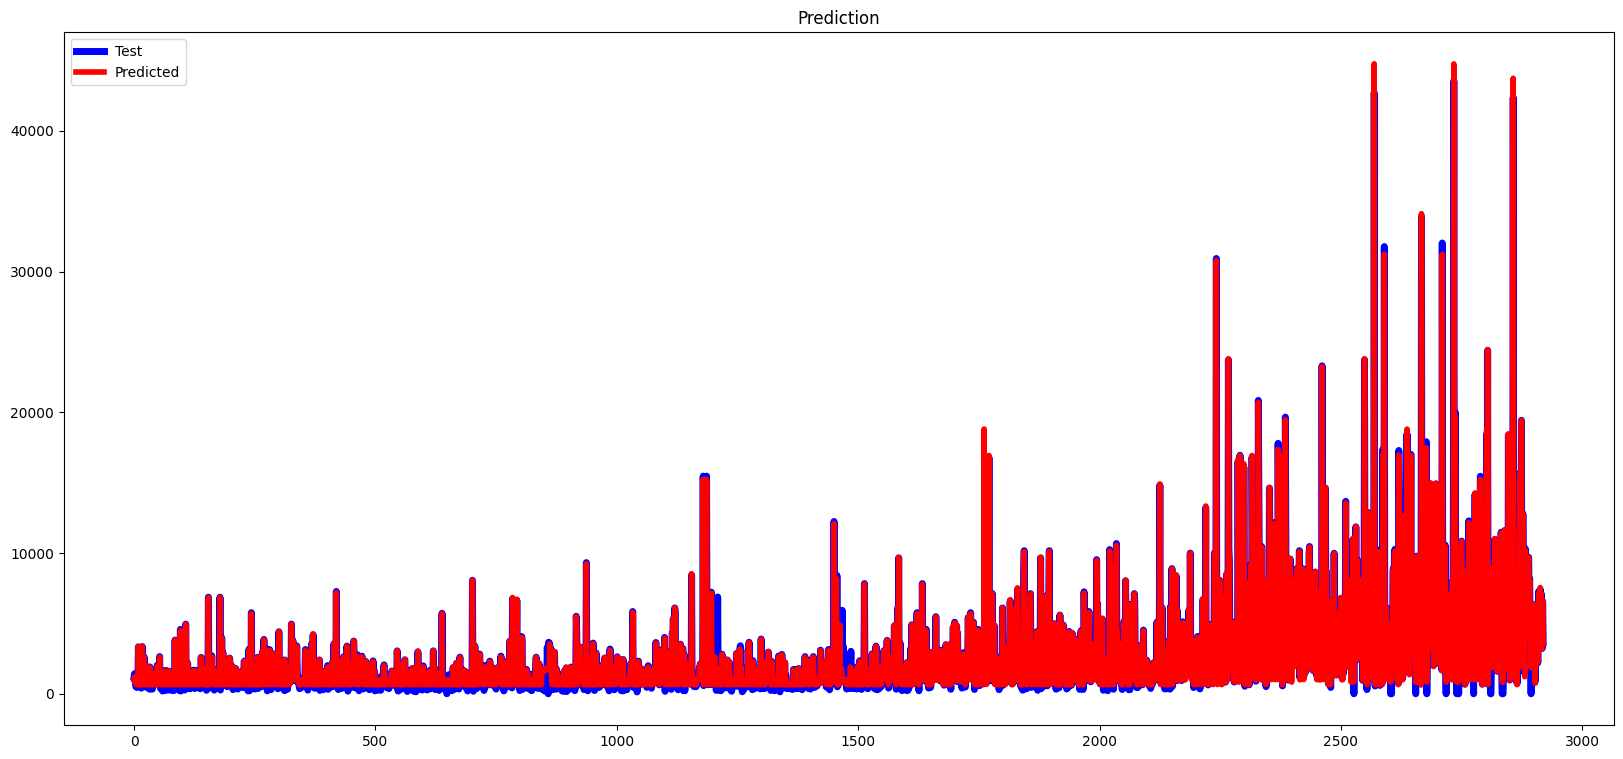

In [265]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(RFpreds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [266]:
score = r2_score(y_test, RFpreds)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 98.0%


### Обучение модели нейросетевой архитектурой глубокого обучения TabNet

In [267]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [268]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [269]:
history = clf.fit(
    X_train=X_train, y_train=y_train,
    # Cписок оцениваемых наборов кортежей (X, y)
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    # Список строковых наборов имен eval
    eval_name=['train', 'valid'],
    # Список показателей оценки
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=50,
    # Количество последовательных периодов без улучшения перед выполнением ранней остановки
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: 29074280.7424| train_rmsle: 13.0635 | train_mae: 2507.39546| train_rmse: 5408.13069| train_mse: 29247877.57623| valid_rmsle: 13.04301| valid_mae: 2395.49098| valid_rmse: 4063.33255| valid_mse: 16510671.40607|  0:00:01s
epoch 1  | loss: 28947104.5062| train_rmsle: 11.21169| train_mae: 2475.37298| train_rmse: 5369.43047| train_mse: 28830783.61014| valid_rmsle: 11.24543| valid_mae: 2365.07246| valid_rmse: 4019.65359| valid_mse: 16157614.97966|  0:00:03s
epoch 2  | loss: 29692898.80486| train_rmsle: 12.10341| train_mae: 2480.23457| train_rmse: 5341.11756| train_mse: 28527536.7414| valid_rmsle: 12.05165| valid_mae: 2369.63324| valid_rmse: 3988.91508| valid_mse: 15911443.4914|  0:00:06s
epoch 3  | loss: 28871558.29235| train_rmsle: 8.97341 | train_mae: 2433.04027| train_rmse: 5276.27698| train_mse: 27839098.72604| valid_rmsle: 8.92521 | valid_mae: 2323.80069| valid_rmse: 3914.77909| valid_mse: 15325495.3253|  0:00:07s
epoch 4  | loss: 28430177.55086| train_rmsle: 5.89408 | t

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [270]:
TNpreds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=TNpreds, y_true=y_true)

In [271]:
# Сохранение модели
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [272]:
# Определение новой модели с базовыми параметрами и весами состояния загрузки
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [273]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"ОКОНЧАТЕЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ {dataset_name} : {loaded_test_mse}")

ОКОНЧАТЕЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ Table : 189840.03171016654


In [274]:
assert(test_score == loaded_test_mse)

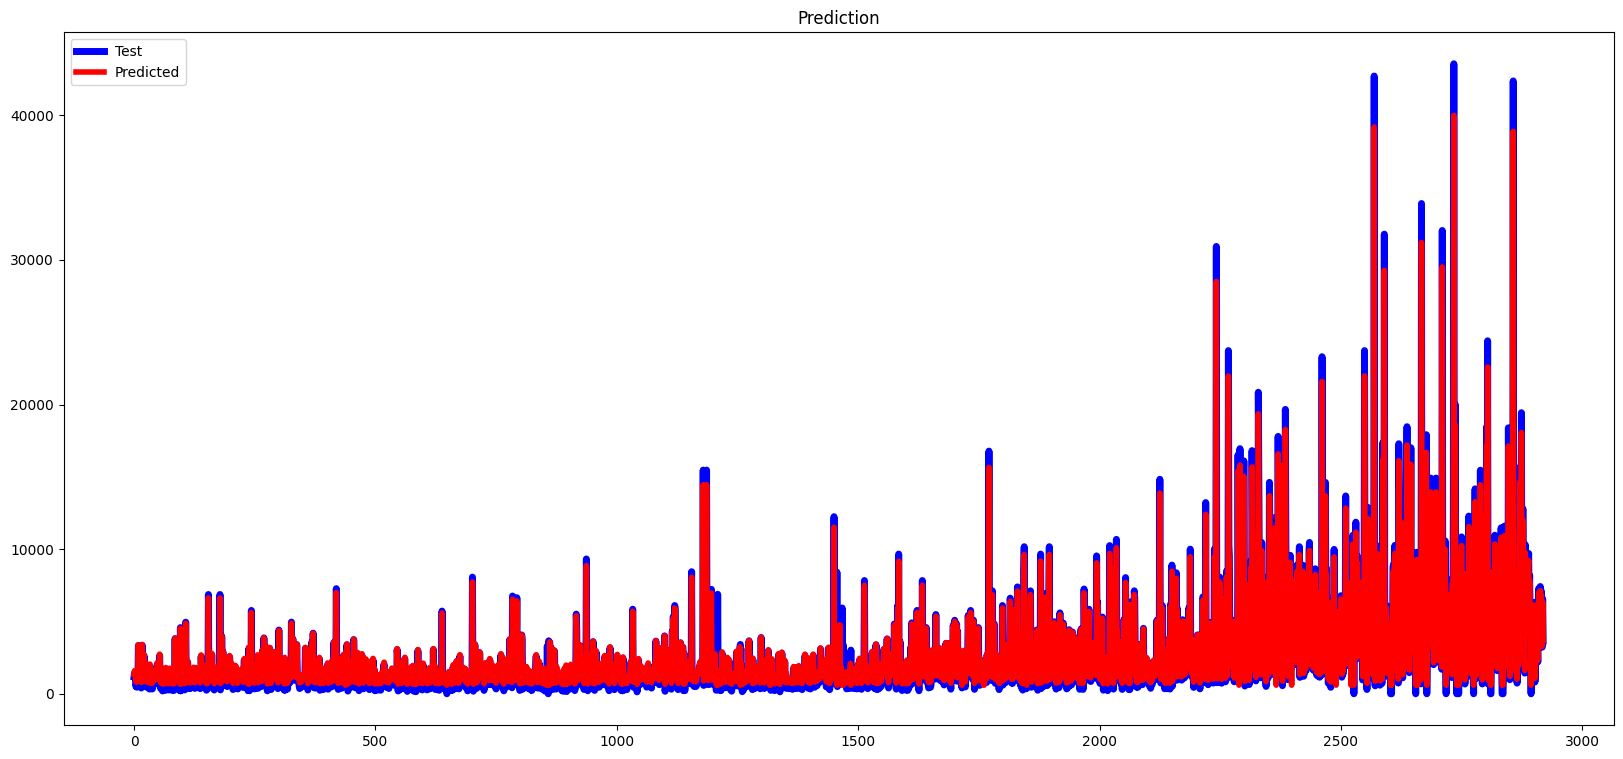

In [275]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(TNpreds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [276]:
score = r2_score(y_true, TNpreds)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 98.0%


### Обучение модели с помощью библиотеки XGBoost

In [277]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Parameter Optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                       {'max_depth': [3,5,7],
                       'n_estimators': [50,100,200]}, verbose=1)
reg_xgb.fit(X_train,y_train)
print(reg_xgb.best_score_)
print(reg_xgb.best_params_)

Parameter Optimization
Fitting 5 folds for each of 9 candidates, totalling 45 fits
-1.0366481952339448
{'max_depth': 7, 'n_estimators': 200}


In [278]:
XGBpreds = reg_xgb.predict(X_test)

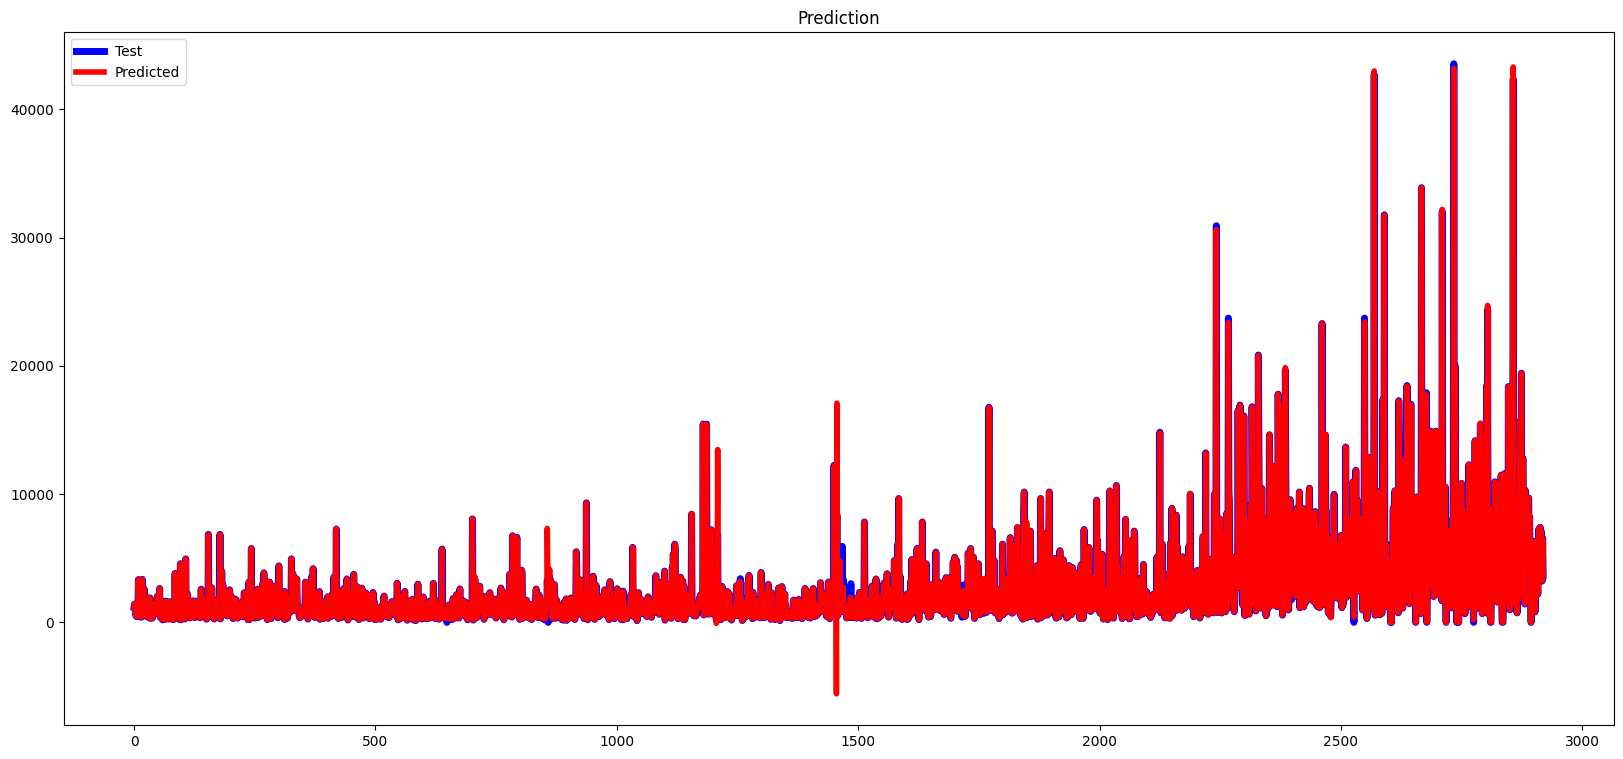

In [279]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(XGBpreds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [280]:
y_true = y_test
score = r2_score(y_true, XGBpreds)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 99.0%


### Обучение модели с помощью библиотеки CatBoost

In [281]:
# !pip install catboost
from catboost import CatBoostRegressor
# Initialize data


# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=3,
                          )
# Fit model
ctb = model.fit(X_train, y_train)
# Get predictions
CTBpreds = ctb.predict(X_test)

0:	learn: 3483.0703997	total: 3.18ms	remaining: 3.18ms
1:	learn: 3371.3922014	total: 7.38ms	remaining: 0us


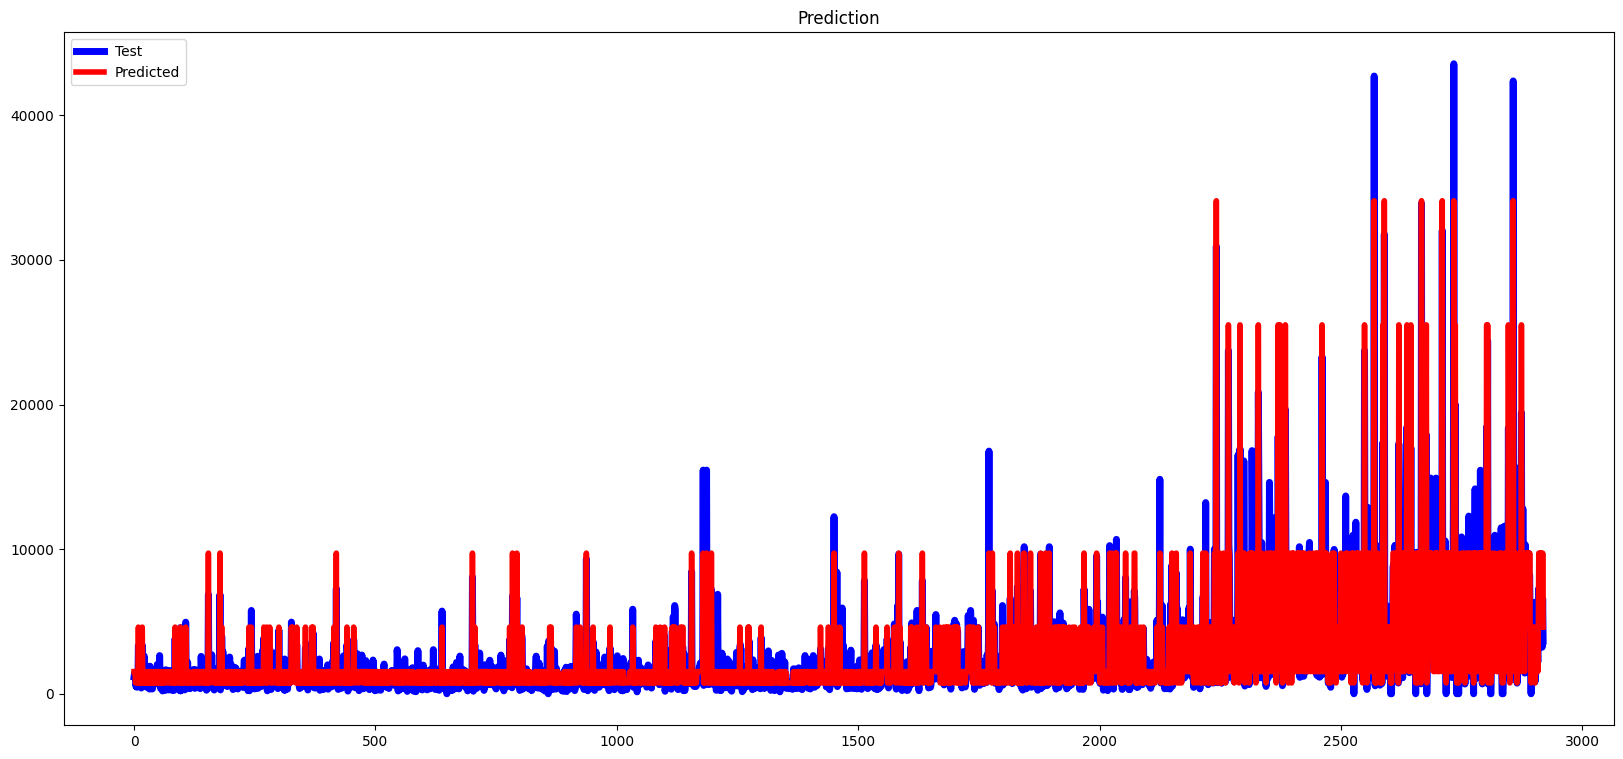

In [282]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(CTBpreds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [283]:
y_true = y_test
score = r2_score(y_true, CTBpreds)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 89.0%


###  Финальный результат обучения модели на основе взвешенного арифметического среднего прогнозов

Помещаю все прогнозы модели в DataFrame

In [284]:
# second feature matrix
RFpreds=np.asanyarray(RFpreds)   
RFpreds=RFpreds.reshape(-1,1)  
TNpreds=np.asanyarray(TNpreds)   
TNpreds=TNpreds.reshape(-1,1) 
XGBpreds=np.asanyarray(XGBpreds)   
XGBpreds=XGBpreds.reshape(-1,1)
CTBpreds=np.asanyarray(CTBpreds)   
CTBpreds=CTBpreds.reshape(-1,1) 

In [285]:
X_train2 = pd.DataFrame( {'RF': RFpreds.flatten(),
     'TN': TNpreds.flatten(),
     'XGB': XGBpreds.flatten(),
     'CTB': CTBpreds.flatten(),
    })
X_train2.head()

,RF,TN,XGB,CTB
0,1004.217613,1375.902466,1174.334473,1534.556598
1,1204.278558,1599.463379,1423.978882,1534.556598
2,989.522233,1325.912109,1117.854126,1534.556598
3,976.634571,1153.960083,914.771729,749.477103
4,648.532947,838.799683,501.474365,749.477103


In [286]:
# second-feature modeling using linear regression
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train2, y_test)

# prediction using the test set
X_test2 = pd.DataFrame( {'RF': RFpreds.flatten(),
     'TN': TNpreds.flatten(),
     'XGB': XGBpreds.flatten(),
     'CTB': CTBpreds.flatten(),
    })

# Non-log scale
y_pred = reg.predict(X_test2)

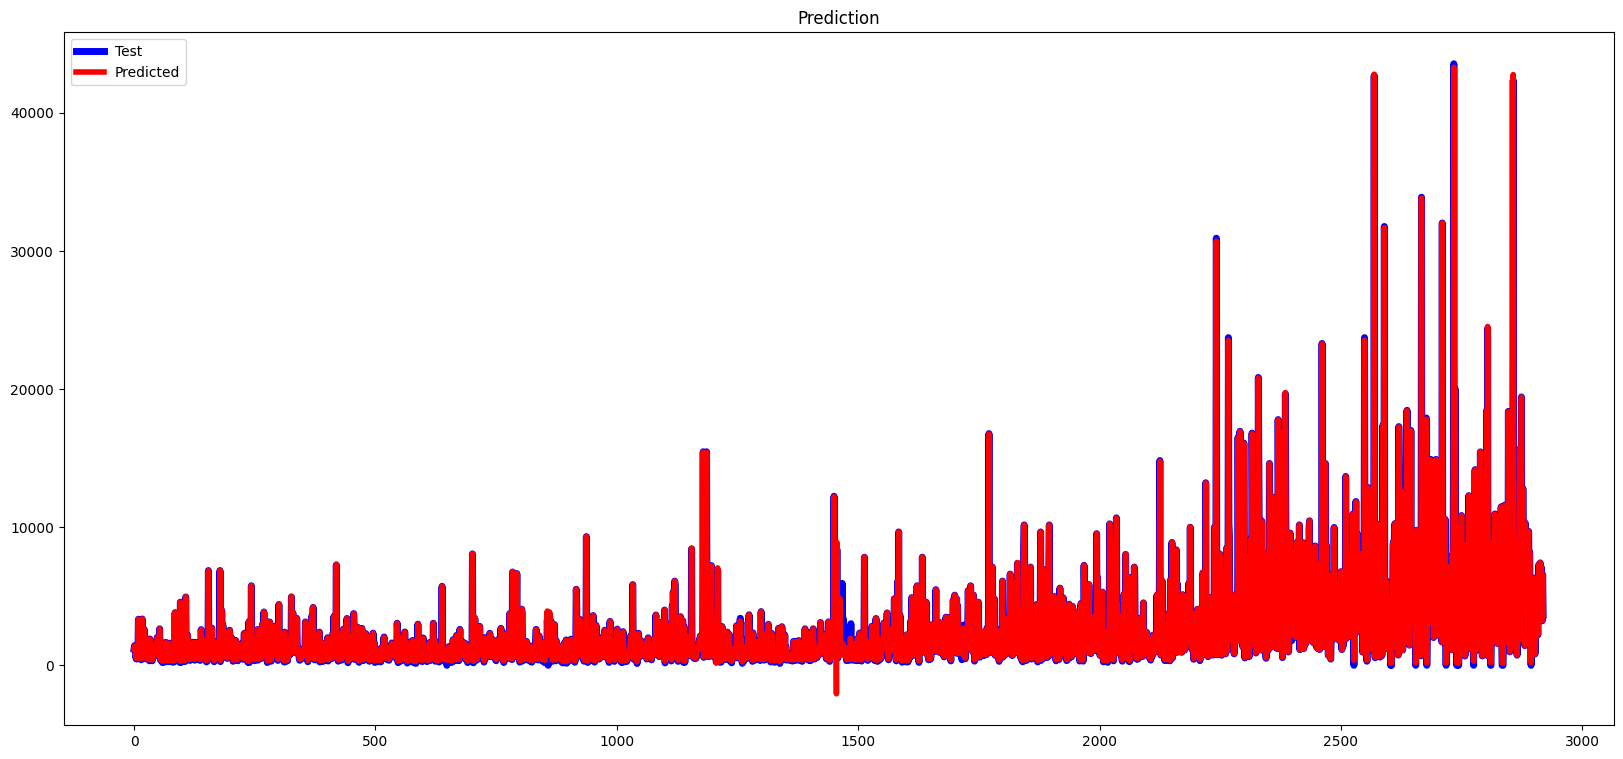

In [287]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(y_pred,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [288]:
score = r2_score(y_true, y_pred)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 100.0%


In [289]:
y_pred=np.asanyarray(y_pred)   
y_pred=y_pred.reshape(-1,1) 
submission = pd.DataFrame({
    # "Id": test_ID,
    "Data": y_pred.flatten()
})

## Show the first thirty predictions
submission[:30]

,Data
0,1159.613069
1,1404.767435
2,1105.465941
3,914.796923
4,536.414788
5,731.530250
6,494.849152
7,719.158520
8,884.412249
9,3340.830262


In [290]:
test = pd.DataFrame(y_test,columns=['Actual'])
pred = pd.DataFrame(y_pred,columns=['Predict'])

In [291]:
results = pd.concat([test,pred],axis=1)

In [292]:
results.head(50)

,Actual,Predict
0,1175.423729,1159.613069
1,1423.728814,1404.767435
2,1118.644068,1105.465941
3,917.796610,914.796923
4,500.000000,536.414788
5,742.372881,731.530250
6,453.372881,494.849152
7,711.864407,719.158520
8,881.355932,884.412249
9,3338.033898,3340.830262


###Создаю прогноз на ближайшее будущее

In [293]:
dataForDates

,Unnamed: 0,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,,
2019-12-27,0,328,1684,796.610169,143.389831,185,4
2019-12-27,1,329,524,355.932203,64.067797,185,2
2019-12-27,2,330,192,901.694915,162.305085,230,4
2019-12-27,3,330,218,182.754237,32.895763,230,1
2019-12-27,4,330,247,780.101695,140.418305,230,4
...,...,...,...,...,...,...,...
2023-01-13,29098,11092,1644,6573.000000,1183.140000,269,1
2023-01-13,29099,11093,352,5179.728814,932.351186,250,4
2023-01-13,29100,11094,683,7741.423729,1393.456271,415,4


In [294]:
timestep = 30
def insert_end(Xin,new_input):
    #print ('Before: \n', Xin , new_input )
    for i in range(timestep-1):
        Xin[i] = Xin[i+1]
    Xin[timestep-1] = new_input
    #print ('After :\n', Xin)
    return Xin

In [295]:
from datetime import timedelta
future=timestep
forcast = []
Xin = X_test2
Xin=np.asanyarray(Xin)   
print(Xin)
time=[]
for i in range(future):
    out = reg.predict(Xin)    
    forcast.append(out[0,0]) 
    print(forcast)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(dataForDates.index[-1])+timedelta(days=i+1))

[[1004.21761325 1375.90246582 1174.33447266 1534.55659766]
 [1204.27855779 1599.46337891 1423.97888184 1534.55659766]
 [ 989.52223264 1325.91210938 1117.85412598 1534.55659766]
 ...
 [3187.94452805 3280.21386719 3222.46777344 4609.13327614]
 [6612.60319181 6360.6484375  6542.62255859 9725.47302621]
 [3602.21058438 3675.36987305 3653.26196289 4609.13327614]]
[1159.6130686966071]
[1159.6130686966071, 1404.7674350308685]
[1159.6130686966071, 1404.7674350308685, 1105.46594134085]
[1159.6130686966071, 1404.7674350308685, 1105.46594134085, 914.7969233135511]
[1159.6130686966071, 1404.7674350308685, 1105.46594134085, 914.7969233135511, 536.4147880833971]
[1159.6130686966071, 1404.7674350308685, 1105.46594134085, 914.7969233135511, 536.4147880833971, 731.5302497213213]
[1159.6130686966071, 1404.7674350308685, 1105.46594134085, 914.7969233135511, 536.4147880833971, 731.5302497213213, 494.84915170364616]
[1159.6130686966071, 1404.7674350308685, 1105.46594134085, 914.7969233135511, 536.4147880833

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

In [296]:
forcasted_output=np.asanyarray(forcast)   
forcasted_output=forcasted_output.reshape(-1,1) 

In [297]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [298]:
dataForDates.columns

Index(['Unnamed: 0', 'InvoiceID', 'ProductID', 'TotalSales', 'Discount',
       'CustomerID', 'Quantity'],
      dtype='object')

In [299]:
df_result

,Date,Forecasted
0,2023-01-15,1159.613069
1,2023-01-16,1404.767435
2,2023-01-17,1105.465941
3,2023-01-18,914.796923
4,2023-01-19,536.414788
5,2023-01-20,731.530250
6,2023-01-21,494.849152
7,2023-01-22,719.158520
8,2023-01-23,884.412249
9,2023-01-24,3340.830262


### График с результатом прогноза на будущие 30 дней

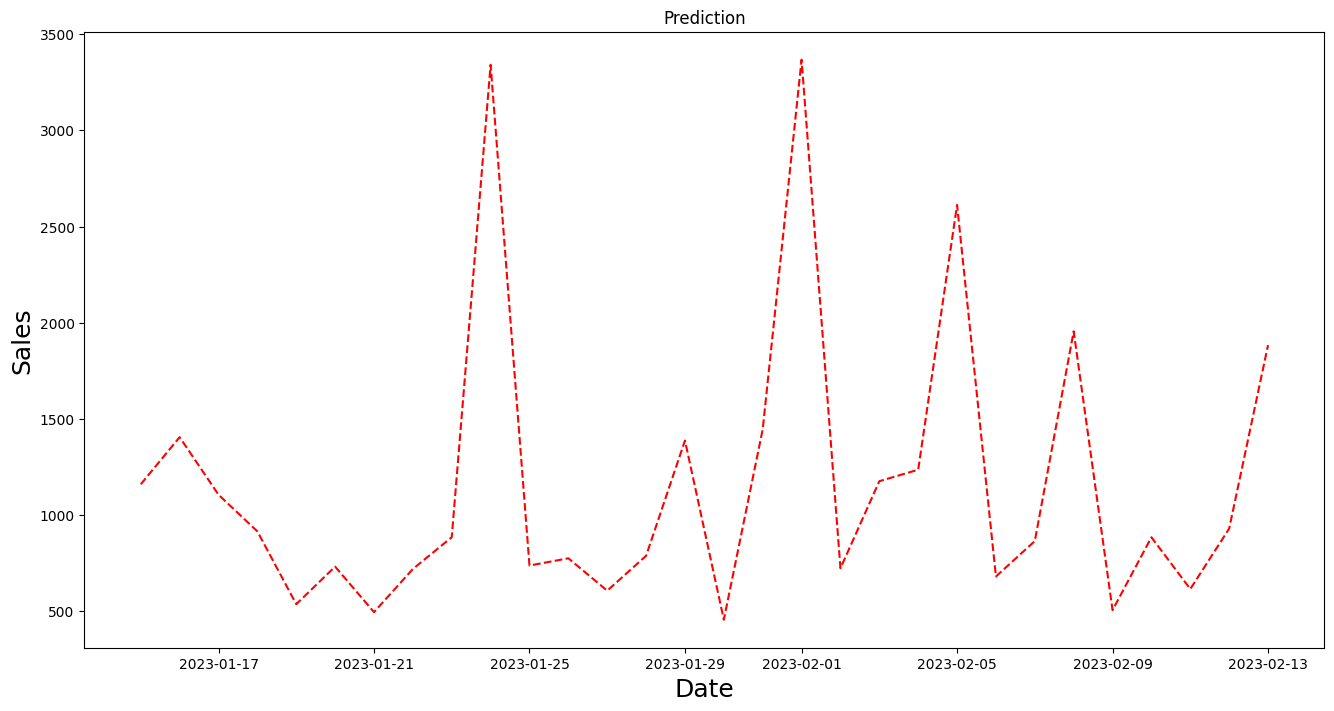

In [300]:
plt.figure(figsize=(16,8))
plt.title('Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales' ,fontsize=18)
plt.plot(df_result.set_index('Date')[['Forecasted']],"r--")